In [2]:
import pandas as pd
import scipy.io
import numpy as np
import scipy.sparse
import src.preprocessing.data_cleaning as data_cleaning
import src.preprocessing.normalization as normalization
import src.preprocessing.feature_selection as feature_selection
import src.preprocessing.dim_reduction as dim_reduction
import src.analysis.clustering as clustering
import src.analysis.cell_identification as cell_identification
import src.evaluation.evaluation as evaluation

metadata_path = "./data/PBMC/PBMC_68k/hg19/68k_pbmc_barcodes_annotation.tsv"
true_labels = evaluation.load_true_labels(metadata_path, "barcodes", "celltype", "\t")
print(true_labels.info())
print(true_labels.head())

def load_expression_data_from_mtx(path, barcodes_labeled=None, n_sample=None, random_state=None):
    """
    Load gene expression data from MTX format into a sparse DataFrame.

    Parameters:
    - path: str, path to the folder with the matrix, genes and barcodes.

    Returns:
    - expression_matrix: Sparse DataFrame containing gene expression data.
    """
    # Load expression matrix
    matrix = scipy.io.mmread(path+"matrix.mtx").tocsc()

    # Load genes
    genes = pd.read_csv(path+"genes.tsv", header=None, sep='\t', names=['gene_id', 'gene_symbol'])

    # Load barcodes
    barcodes = pd.read_csv(path+"barcodes.tsv", header=None, sep='\t', names=['barcode'])

    # Filter by labeled barcodes if barcodes_labeled is provided
    if barcodes_labeled is not None:
        if 'barcode' not in barcodes_labeled.columns:
            raise ValueError("The provided barcodes_labeled DataFrame must contain a 'barcode' column.")
        # Find the intersection of barcodes
        labeled_barcodes = set(barcodes_labeled['barcode'])
        matching_indices = barcodes['barcode'].isin(labeled_barcodes)
        matrix = matrix[:, matching_indices]
        barcodes = barcodes[matching_indices]

    # Apply random sampling to barcodes if n_sample is specified
    if n_sample is not None and n_sample < len(barcodes):
        np.random.seed(random_state)
        sampled_indices = np.random.choice(len(barcodes), size=n_sample, replace=False)
        matrix = matrix[:, sampled_indices]  # Subset columns (barcodes)
        barcodes = barcodes.iloc[sampled_indices]

    # Transform sparse matrix into pandas sparse DataFrame
    expression_matrix = pd.DataFrame.sparse.from_spmatrix(matrix)
    expression_matrix.index = genes['gene_symbol']
    expression_matrix.columns = barcodes['barcode']

    expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)

    return expression_matrix

expression_matrix = load_expression_data_from_mtx("./data/PBMC/PBMC_68k/hg19/", barcodes_labeled=true_labels, n_sample=1000, random_state=6)

print(expression_matrix.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29733 entries, nan to nan
Columns: 6178 entries, CID3586_AAGACCTCAGCATGAG to CID3586_TTGCCGTTCAGAAATG
dtypes: Sparse[int64, 0](6178)
memory usage: 70.1 MB
None
Done


In [4]:
duplicated_genes = expression_matrix.index[expression_matrix.index.duplicated()]
if len(duplicated_genes) > 0:
    print(f"Genes duplicados encontrados: {duplicated_genes}")

Genes duplicados encontrados: Index(['U1', 'EFNA3', 'DCAF8', 'MRPL30', 'LIMS3', 'KRBOX1', 'TLR9', 'RPP14',
       'CRYBG3', 'TM4SF19', 'UGT2A1', 'FAM47E-STBD1', 'CKS1B', 'CFB', 'TAP2',
       'SOGA3', 'AQP1', 'PSMA2', 'MRPS17', 'MUC3A', 'POLR2J2', 'IDS', 'SOX7',
       'DEFB130', 'OC90', 'ZFP41', '7SK', 'GALT', 'ANKRD18A', 'LCN6',
       'TMEM236', 'PI4K2A', 'GOLGA7B', 'NDUFB8', 'TIMM10B', 'PSMA1', 'KBTBD4',
       'ALG9', 'SDHD', 'MFRP', 'HOXC4', 'TMBIM4', 'SNORA40', 'LSP1', 'RNASE11',
       'TM9SF1', 'LTB4R2', 'KIAA0391', 'MDGA2', 'CCDC177', 'CRIP1', 'SNURF',
       'CELF6', 'ITFG3', 'NAA60', 'NPIPA7', 'NPIPA7', 'CLN3', 'PAGR1', 'SEPT1',
       'ZNF747', 'ZNF668', 'Y_RNA', 'CHTF8', '7SK', 'TUBB3', 'SHPK', 'CDRT1',
       'ZNF286A', 'Y_RNA', 'KRT222', 'ITGB3', 'ACE', 'SLC25A10', 'IER3IP1',
       'TMEM239', 'RBL1', 'UQCR11', 'NDUFA7', 'ZNF763', 'ZNF788', 'ZNF709',
       'PIK3R2', 'ZNF223', 'KLK9', 'SIGLEC5', 'ZNF8', '7SK', 'SLC5A3', 'FRG2C',
       'ZNF84', 'ZNF26', 'KIR3DL2', 'PNRC

In [5]:
from importlib import reload
reload(data_cleaning)
print("\tMatrix 1")
cleaned_matrix1 = data_cleaning.filter_lowly_expressed_genes(expression_matrix)
print(cleaned_matrix1.info())

print("\tMatrix 2")
cleaned_matrix2 = data_cleaning.filter_high_mitochondrial_content(expression_matrix)
print(cleaned_matrix2.info())

print("\tMatrix 3")
cleaned_matrix3 = data_cleaning.filter_doublets_cxds(expression_matrix)
print(cleaned_matrix3.info())

print("\tMatrix Combined")
cleaned_matrix_combined = data_cleaning.combined_cleaning(expression_matrix)
print(cleaned_matrix_combined.info())


	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, ISG15 to UQCR11
Columns: 500 entries, CTCGAAGATTCCAT-1 to AATGCGTGTCCAAG-3
dtypes: Sparse[float64, 0](500)
memory usage: 29.8+ KB
None
	Matrix 2
<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Data columns (total 90 columns):
 #   Column            Non-Null Count  Dtype             
---  ------            --------------  -----             
 0   TACTACACGGTGGA-3  32643 non-null  Sparse[float64, 0]
 1   CTACTCCTATTCGG-8  32643 non-null  Sparse[float64, 0]
 2   GATAGCACGTAGCT-1  32643 non-null  Sparse[float64, 0]
 3   GGAGACGAAAGTGA-8  32643 non-null  Sparse[float64, 0]
 4   CACATACTACTTTC-2  32643 non-null  Sparse[float64, 0]
 5   GAGTTGTGCCGTTC-7  32643 non-null  Sparse[float64, 0]
 6   TCACAACTACCTCC-4  32643 non-null  Sparse[float64, 0]
 7   GGCATATGACCCTC-1  32643 non-null  Sparse[float64, 0]
 8   CTGCAGCTGTCGAT-5  32643 non-null  Sparse[float64, 0]
 9   TAAGATTGGCAAGG-4  32643 non-nul

In [6]:
duplicated_genes = cleaned_matrix_combined.index[cleaned_matrix_combined.index.duplicated()]
if len(duplicated_genes) > 0:
    print(f"Genes duplicados encontrados: {duplicated_genes}")

In [7]:
reload(normalization)
print("\tMatrix 1")
norm_matrix1 = normalization.normalize_cpm(cleaned_matrix_combined)
print(norm_matrix1.info())

print("\tMatrix 2")
norm_matrix2 = normalization.normalize_quantile_regression(cleaned_matrix_combined)
print(norm_matrix2.info())

print("\tMatrix 3")
norm_matrix3 = normalization.normalize_negative_binomial(cleaned_matrix_combined)
print(norm_matrix3.info())


	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, ISG15 to UQCR11
Data columns (total 90 columns):
 #   Column            Non-Null Count  Dtype               
---  ------            --------------  -----               
 0   TACTACACGGTGGA-3  414 non-null    Sparse[float64, nan]
 1   CTACTCCTATTCGG-8  414 non-null    Sparse[float64, nan]
 2   GATAGCACGTAGCT-1  414 non-null    Sparse[float64, nan]
 3   GGAGACGAAAGTGA-8  414 non-null    Sparse[float64, nan]
 4   CACATACTACTTTC-2  414 non-null    Sparse[float64, nan]
 5   GAGTTGTGCCGTTC-7  414 non-null    Sparse[float64, nan]
 6   TCACAACTACCTCC-4  414 non-null    Sparse[float64, nan]
 7   GGCATATGACCCTC-1  414 non-null    Sparse[float64, nan]
 8   CTGCAGCTGTCGAT-5  414 non-null    Sparse[float64, nan]
 9   TAAGATTGGCAAGG-4  414 non-null    Sparse[float64, nan]
 10  TTGAATGATTGTGG-3  414 non-null    Sparse[float64, nan]
 11  ATAGAACTCTTATC-5  414 non-null    Sparse[float64, nan]
 12  GGAGGCCTCTCTCG-1  414 non-null    Spar

In [9]:
# Feature selection
reload(feature_selection)
print("\tMatrix 1")
selected_matrix1 = feature_selection.select_highly_variable_genes(norm_matrix3)
print(selected_matrix1.info())

print("\tMatrix 2")
selected_matrix2 = feature_selection.select_genes_by_variance(norm_matrix3)
print(selected_matrix2.info())

	Matrix 1
<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, MALAT1 to CRIP1
Data columns (total 90 columns):
 #   Column            Non-Null Count  Dtype             
---  ------            --------------  -----             
 0   TACTACACGGTGGA-3  414 non-null    Sparse[float64, 0]
 1   CTACTCCTATTCGG-8  414 non-null    Sparse[float64, 0]
 2   GATAGCACGTAGCT-1  414 non-null    Sparse[float64, 0]
 3   GGAGACGAAAGTGA-8  414 non-null    Sparse[float64, 0]
 4   CACATACTACTTTC-2  414 non-null    Sparse[float64, 0]
 5   GAGTTGTGCCGTTC-7  414 non-null    Sparse[float64, 0]
 6   TCACAACTACCTCC-4  414 non-null    Sparse[float64, 0]
 7   GGCATATGACCCTC-1  414 non-null    Sparse[float64, 0]
 8   CTGCAGCTGTCGAT-5  414 non-null    Sparse[float64, 0]
 9   TAAGATTGGCAAGG-4  414 non-null    Sparse[float64, 0]
 10  TTGAATGATTGTGG-3  414 non-null    Sparse[float64, 0]
 11  ATAGAACTCTTATC-5  414 non-null    Sparse[float64, 0]
 12  GGAGGCCTCTCTCG-1  414 non-null    Sparse[float64, 0]
 13  CCTCATCT

In [10]:
# Dim reduction
reload(dim_reduction)
print("\tPCA")
pca_object, pca_matrix = dim_reduction.apply_pca(selected_matrix1)
print(pca_matrix.info())
print(pca_object)
print(pca_matrix.shape[1])

print("\tUMAP")
umap_matrix = dim_reduction.apply_umap(selected_matrix1, pca_matrix.shape[1])
print(umap_matrix.info())

print("\tt-SNE")
tsne_matrix = dim_reduction.apply_tsne(selected_matrix1, 2)
print(tsne_matrix.info())

	PCA
<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, TACTACACGGTGGA-3 to AATGCGTGTCCAAG-3
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC_1    90 non-null     float64
 1   PC_2    90 non-null     float64
 2   PC_3    90 non-null     float64
 3   PC_4    90 non-null     float64
 4   PC_5    90 non-null     float64
 5   PC_6    90 non-null     float64
 6   PC_7    90 non-null     float64
 7   PC_8    90 non-null     float64
 8   PC_9    90 non-null     float64
dtypes: float64(9)
memory usage: 9.1+ KB
None
PCA()
9
	UMAP
<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, TACTACACGGTGGA-3 to AATGCGTGTCCAAG-3
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UMAP_1  90 non-null     float32
 1   UMAP_2  90 non-null     float32
 2   UMAP_3  90 non-null     float32
 3   UMAP_4  90 non-null     float32
 4   UMAP_5  90 non-null     float32
 5   UMAP_6  90 n

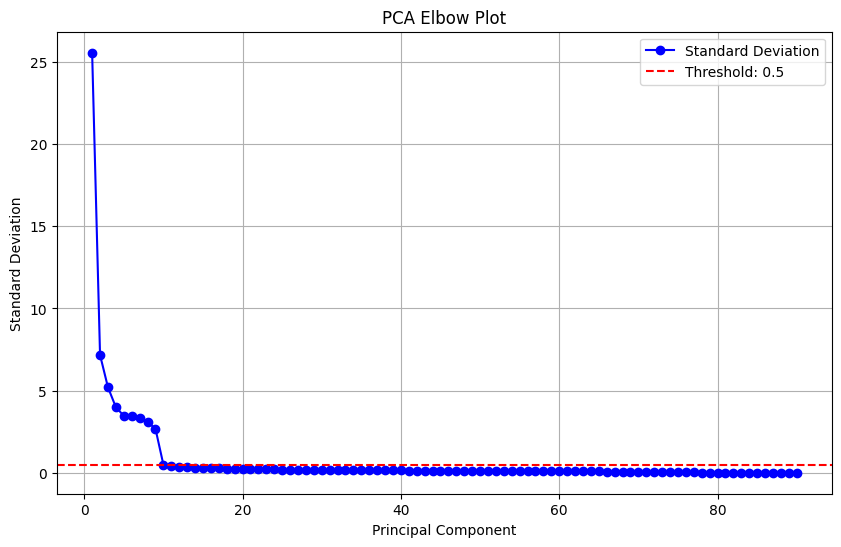

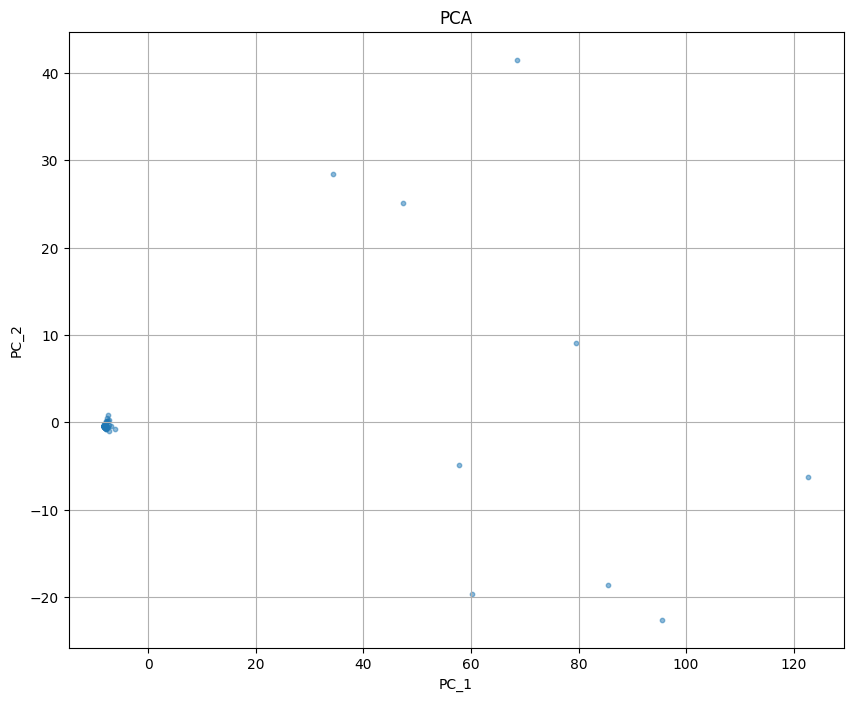

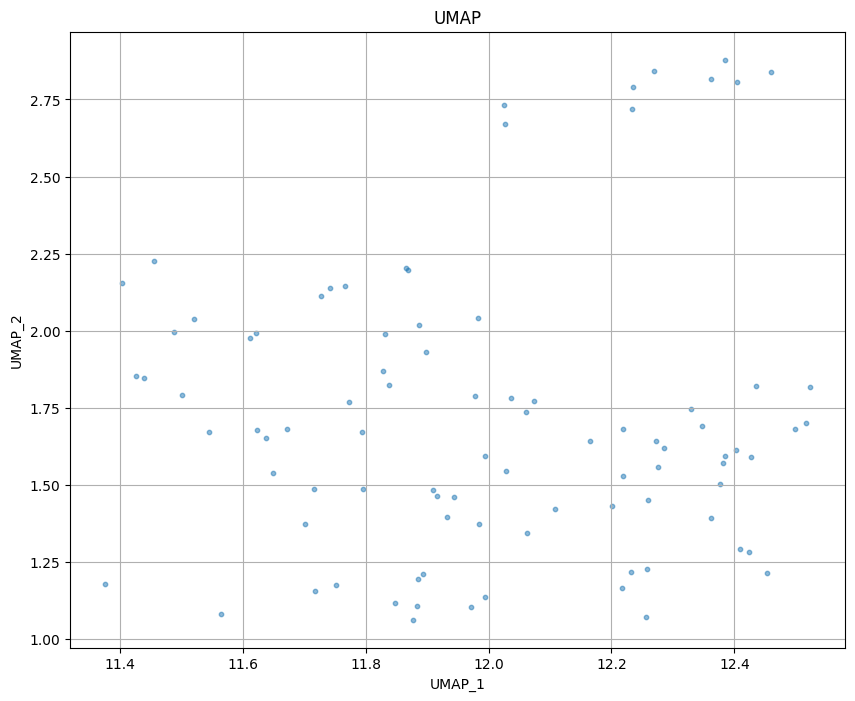

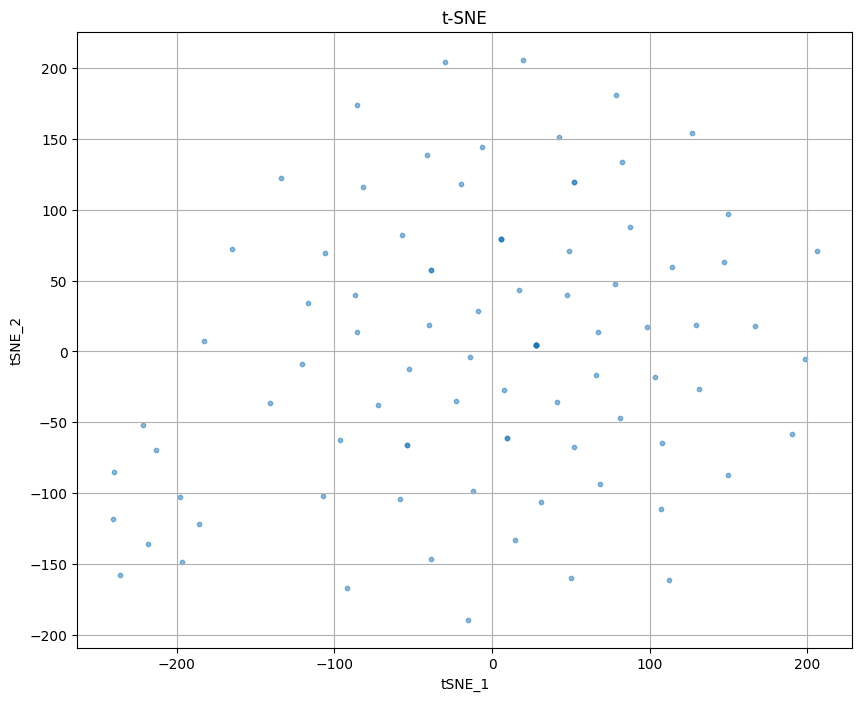

In [11]:
# Visualization
reload(dim_reduction)
# elbow plot
dim_reduction.elbow_plot(pca_object)
# visualization
dim_reduction.visualize_dim_reduction(pca_matrix.iloc[:, :2], 'PCA')
dim_reduction.visualize_dim_reduction(umap_matrix.iloc[:, :2], 'UMAP')
dim_reduction.visualize_dim_reduction(tsne_matrix.iloc[:, :2], 't-SNE')


In [12]:
# Clustering
reload(clustering)
print("\tGraph based")
clustering1 = clustering.graph_based_clustering_leiden(pca_matrix)
print(clustering1.head())

print("\tDensity based")
clustering2 = clustering.density_based_clustering(pca_matrix)
print(clustering2.head())

print("\tDistance based")
clustering3 = clustering.distance_based_clustering(pca_matrix)
print(clustering3.head())

print("\tHierarchical")
clustering4 = clustering.hierarchical_clustering(pca_matrix)
print(clustering4.head())

print("\tDeep Learning")
clustering5 = clustering.deep_learning_clustering(pca_matrix)
print(clustering5.head())

print("\tAffinity propagation")
clustering6 = clustering.affinity_propagation_clustering(pca_matrix)
print(clustering6.head())

print("\tMixture model")
clustering7 = clustering.mixture_model_clustering(pca_matrix, n_components=pca_matrix.shape[1])
print(clustering7.head())

print("\tEnsemble")
clustering8 = clustering.ensemble_clustering(pca_matrix, n_clusters=10, n_components=pca_matrix.shape[1])
print(clustering8.head())


	Graph based
barcode
TACTACACGGTGGA-3    4
CTACTCCTATTCGG-8    1
GATAGCACGTAGCT-1    1
GGAGACGAAAGTGA-8    1
CACATACTACTTTC-2    2
dtype: int32
	Density based
barcode
TACTACACGGTGGA-3    0
CTACTCCTATTCGG-8    0
GATAGCACGTAGCT-1    0
GGAGACGAAAGTGA-8    0
CACATACTACTTTC-2   -1
dtype: int64
	Distance based
barcode
TACTACACGGTGGA-3    0
CTACTCCTATTCGG-8    0
GATAGCACGTAGCT-1    0
GGAGACGAAAGTGA-8    0
CACATACTACTTTC-2    6
dtype: int32
	Hierarchical
barcode
TACTACACGGTGGA-3    0
CTACTCCTATTCGG-8    0
GATAGCACGTAGCT-1    0
GGAGACGAAAGTGA-8    0
CACATACTACTTTC-2    6
dtype: int64
	Deep Learning
Epoch 1/50
1/1 [==============================] - 1s 667ms/step - loss: 88.1432
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 88.1217
Epoch 3/50
1/1 [==============================] - 0s 9ms/step - loss: 88.0991
Epoch 4/50
1/1 [==============================] - 0s 5ms/step - loss: 88.0759
Epoch 5/50
1/1 [==============================] - 0s 8ms/step - loss: 88.0537
Epoch 6/50


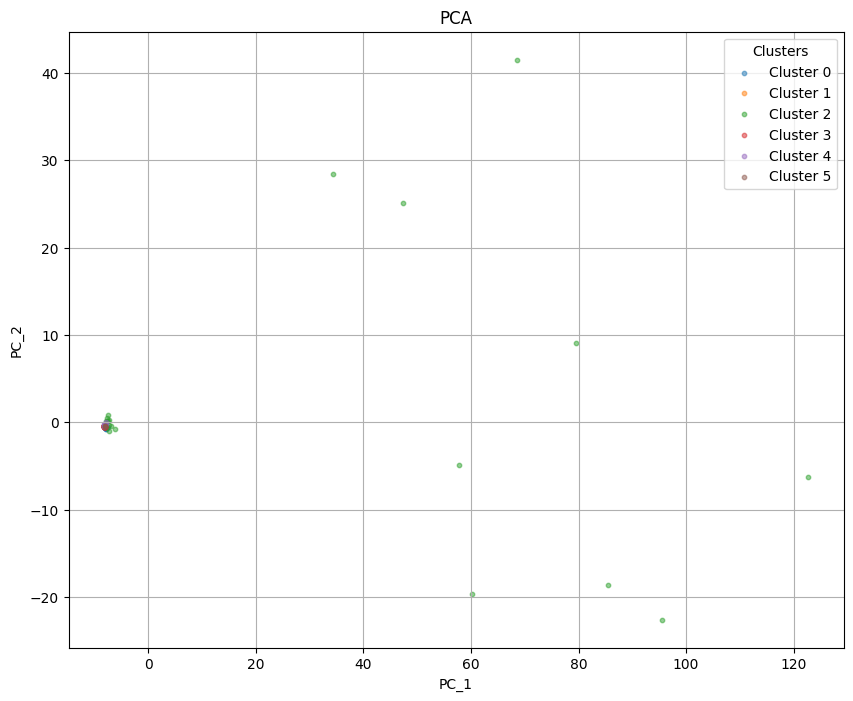

In [14]:
# Clustering visualization
reload(clustering)
clustering.visualize_clusters(pca_matrix, 'PCA', clustering1)

	Expression profile
<class 'pandas.core.frame.DataFrame'>
Index: 32643 entries, MIR1302-10 to ZNF84
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CD56+ NK                      32643 non-null  float64
 1   CD8+ Cytotoxic T              32643 non-null  float64
 2   CD8+/CD45RA+ Naive Cytotoxic  32643 non-null  float64
dtypes: float64(3)
memory usage: 1020.1+ KB
None
celltype      CD56+ NK  CD8+ Cytotoxic T  CD8+/CD45RA+ Naive Cytotoxic
gene_symbol                                                           
MIR1302-10         0.0               0.0                           0.0
FAM138A            0.0               0.0                           0.0
OR4F5              0.0               0.0                           0.0
RP11-34P13.7       0.0               0.0                           0.0
RP11-34P13.8       0.0               0.0                           0.0
	Marker reference
[('CD56+ 

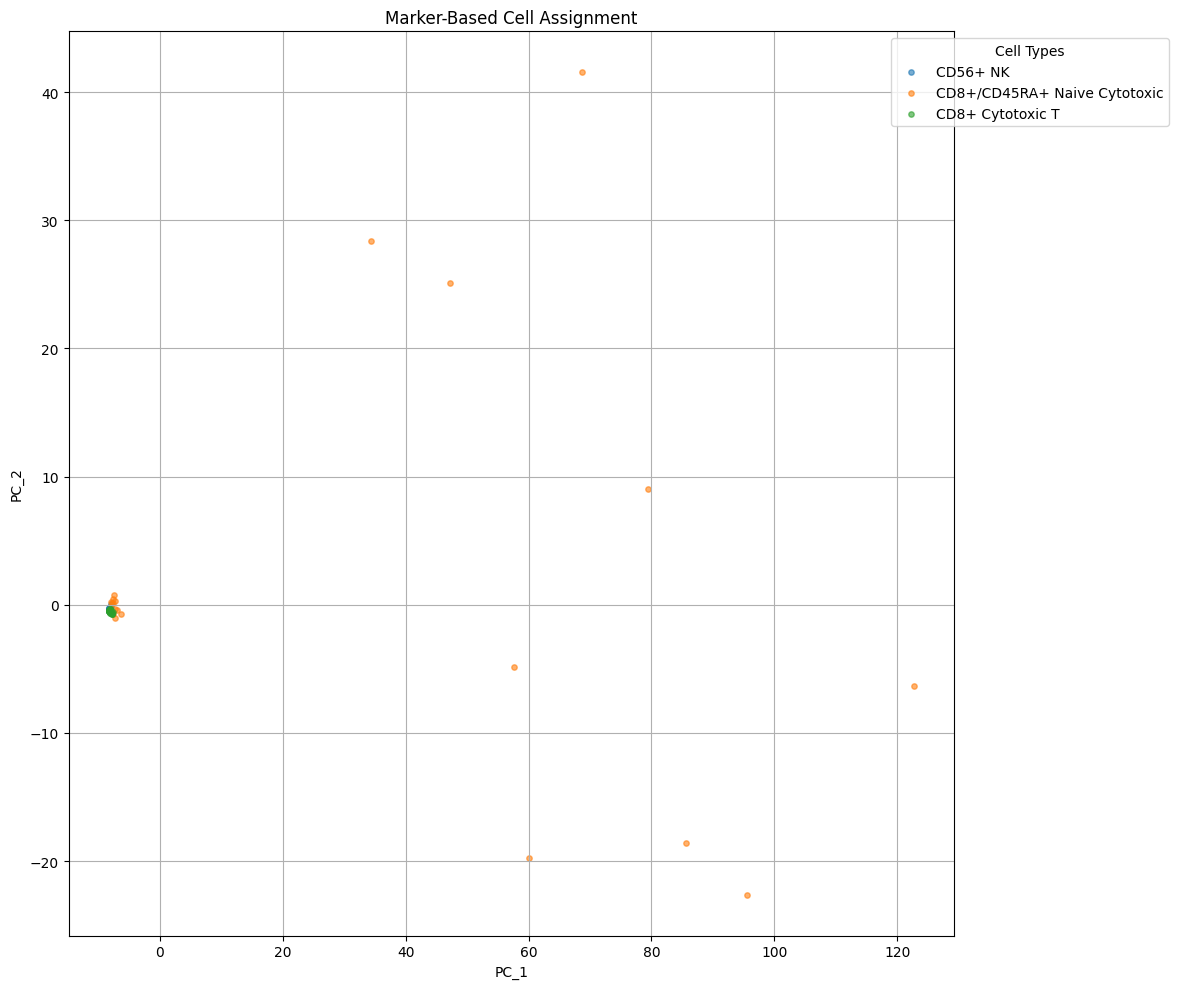

In [30]:
# Cell identification
reload(cell_identification)
expression_matrix = data_cleaning.remove_duplicated_genes(expression_matrix)
print("\tExpression profile")
expression_profile = cell_identification.generate_expression_profiles(expression_matrix, metadata_path, celltype_column='celltype', sep='\t')
print(expression_profile.info())
print(expression_profile.head())

print("\tMarker reference")
marker_genes = cell_identification.generate_marker_reference(expression_matrix, metadata_path, celltype_column='celltype', sep='\t')
print(list(marker_genes.items())[:5])

print("\tReference based")
cell_id_1 = cell_identification.reference_based_assignment(selected_matrix1, clustering1, expression_profile)
print(cell_id_1.head(10))

print("\tCorrelation based")
cell_id_2 = cell_identification.correlation_based_assignment(selected_matrix1, clustering1, expression_profile)
print(cell_id_2.head(10))

print("\tMarker based")
cell_id_3 = cell_identification.marker_based_assignment(selected_matrix1, clustering1, marker_genes)
print(cell_id_3.head(10))

cell_identification.visualize_cells(pca_matrix, "Marker-Based Cell Assignment", cell_id_3)

In [34]:
# Evaluation metrics
reload(evaluation)
print("\tInternal evaluation")
internal_results = evaluation.internal_evaluation(pca_matrix, cell_id_1)
print(internal_results)

print("\tExternal evaluation")
external_results = evaluation.external_evaluation(cell_id_1, true_labels)
print(external_results)

	Internal evaluation
{'Silhouette_Score': -0.008994260282809958, 'ARI': 0.44553172276353403, 'NMI': 0.702331270804636, 'V_measure': 0.702331270804636}
	External evaluation
{'Accuracy': 0.3333333333333333, 'Precision': 0.1111111111111111, 'Recall': 0.3333333333333333, 'F1_score': 0.16666666666666666}


In [35]:
# Save results
import os
def save_results(pipeline_id, cell_identification_results, internal_metrics,
                 external_metrics, reduced_matrix, tissue):
    """
        Save the results of the pipeline including clustering, cell identification, and metrics.

        Parameters:
        -----------
        pipeline_id : str
            Unique identifier for the pipeline configuration.
        cell_identification_results : pd.DataFrame
            DataFrame containing 'barcode', 'cluster', and 'celltype' columns.
        internal_metrics : dict
            Dictionary containing internal evaluation metrics such as ARI, Silhouette, etc.
        external_metrics : dict
            Dictionary containing external evaluation metrics such as Accuracy, Precision, etc.
        reduced_matrix : pd.DataFrame
            Reduced dimensionality matrix (cells x dimensions).
        tissue : str
            Name of the tissue analyzed (e.g. PBMC).
        """
    # Create the results folder for the tissue if it doesn't exist
    tissue_results_path = f'results/{tissue}_results'
    os.makedirs(tissue_results_path, exist_ok=True)

    # Create the reduced matrix folder for the tissue if it doesn't exist
    tissue_reduced_matrix_path = f'{tissue_results_path}/{tissue}_reduced_matrix'
    os.makedirs(tissue_reduced_matrix_path, exist_ok=True)

    # Create a new row with the results of the pipeline
    result_row = {
        'pipeline_id': pipeline_id,  # Unique identifier for the pipeline
        'barcodes': ','.join(cell_identification_results['barcode'].tolist()),  # Convert the barcode list to a comma-separated string
        'clusters': ','.join(map(str, cell_identification_results['cluster'].tolist())),  # Convert clusters to string
        'cell_types': ','.join(cell_identification_results['celltype'].tolist()),  # Convert cell types to string
        'ARI': internal_metrics['ARI'],
        'Silhouette_Score': internal_metrics['Silhouette_Score'],
        'NMI': internal_metrics['NMI'],
        'V_measure': internal_metrics['V_measure'],
        'Accuracy': external_metrics['Accuracy'],
        'Precision': external_metrics['Precision'],
        'Recall': external_metrics['Recall'],
        'F1_score': external_metrics['F1_score']
    }

    # Save the results to a CSV file
    results_df = pd.DataFrame([result_row])

    # Check if the file already exists
    results_file_path = f'{tissue_results_path}/{tissue}_all_results.csv'
    if not os.path.exists(results_file_path):
        # If it doesn't exist, create it with headers
        results_df.to_csv(results_file_path, index=False, mode='w', header=True)
    else:
        # If it exists, append the new row without headers
        results_df.to_csv(results_file_path, index=False, mode='a', header=False)

    # Save the reduced dimensionality matrix in compressed format (CSV gzip) in the tissue-specific folder
    reduced_matrix_file_path = f'{tissue_reduced_matrix_path}/{pipeline_id}_matrix.csv.gz'
    reduced_matrix.to_csv(reduced_matrix_file_path, index=False, compression='gzip')

    print(f"Results for pipeline {pipeline_id} saved successfully.")

print("\tSave results")
pipeline_id = 'pipeline_1'
save_results(pipeline_id, cell_id_1, internal_results,
                 external_results, pca_matrix, 'PBMC')

	Save results
Results for pipeline pipeline_1 saved successfully.


In [ ]:
# Execute step
def execute_step(step_name, methods_dict, method_name, data, extra_params=None):
    """
    Execute a specific step using the provided method.

    Parameters:
    -----------
    step_name : str
        The name of the pipeline step (e.g., 'data_cleaning', 'normalization', etc.).
    methods_dict : dict
        Dictionary containing methods for the current step.
    method_name : str
        The name of the method to be executed.
    data : pd.DataFrame
        The data to be processed by the method.
    extra_params : dict, optional
        Additional parameters required by the method (e.g., file paths, metadata).

    Returns:
    --------
    result : pd.DataFrame or pd.Series
        The result of the executed method.
    """
    method_func = methods_dict[method_name]
    print(f"Running {step_name} - {method_name}")
    if extra_params:
        result = method_func(data, **extra_params) # If the function needs extra_params, call it with them
    else:
        result = method_func(data)  # Else, no extra_params is needed
    return result

# Dictionary
clustering_methods = {
    'GBC': {'func': clustering.graph_based_clustering_leiden, 'params': {'resolution': 1}},
    'DeBC': {'func': clustering.density_based_clustering, 'params': {'eps': 0.5, 'min_samples': 5}},
    'DiBC': {'func': clustering.distance_based_clustering, 'params': {'n_clusters': 10}},
    'HC': {'func': clustering.hierarchical_clustering, 'params': {'n_clusters': 5}},
    'DLC': {'func': clustering.deep_learning_clustering, 'params': {'n_clusters': 10, 'encoding_dim': 32}},
    'APC': {'func': clustering.affinity_propagation_clustering, 'params': None},
    'MMC': {'func': clustering.mixture_model_clustering, 'params': {'n_components': 10}},  # n_components is n_clusters
    'EC': {'func': clustering.ensemble_clustering, 'params': {'n_estimators': 10}},
}

for cluster_method, cluster_config in clustering_methods.items():
    result_step = execute_step('Clustering', clustering_methods, 'GBC', pca_matrix, cluster_config['params'])
    print(result_step.info())


In [ ]:
import os
import pandas as pd
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix

# Directorio con las carpetas
base_dir = "./data/Tumor" 
folders = ["CID3586", "CID3838", "CID3921", "CID3941", "CID3946", "CID3948", 
           "CID3963", "CID4040", "CID4066", "CID4465", "CID4495", "CID44041"]

# Inicialización de estructuras combinadas
combined_metadata = pd.DataFrame()
gene_index = set()
matrices = []

# Recorrer todas las carpetas
for folder in folders:
    folder_path = os.path.join(base_dir, folder)

    # Leer la matriz dispersa
    matrix_path = os.path.join(folder_path, "count_matrix_sparse.mtx")
    sparse_matrix = mmread(matrix_path).tocsr()

    # Leer el metadata.csv
    metadata_path = os.path.join(folder_path, "metadata.csv")
    metadata = pd.read_csv(metadata_path)

    # Seleccionar solo las columnas necesarias
    metadata = metadata.iloc[:, [0]].join(metadata[["celltype_minor"]])

    # Agregar los barcodes como índices de la metadata
    barcodes = metadata.iloc[:, 0].values
    if sparse_matrix.shape[1] != len(barcodes):
        raise ValueError(f"El número de columnas en {matrix_path} no coincide con los barcodes en {metadata_path}")

    # Actualizar el índice maestro de genes
    genes_path = os.path.join(folder_path, "count_matrix_genes.tsv")  # Asegúrate de que exista un archivo con los nombres de genes
    genes = pd.read_csv(genes_path, sep='\t', header=None)[0].tolist()
    gene_index.update(genes)

    # Guardar la matriz y los barcodes para reindexar más adelante
    matrices.append((sparse_matrix, genes, barcodes))

    # Actualizar la metadata combinada
    combined_metadata = pd.concat([combined_metadata, metadata], ignore_index=True)

# Crear índice maestro ordenado de genes
gene_index = sorted(gene_index)
gene_to_idx = {gene: idx for idx, gene in enumerate(gene_index)}

# Inicializar la matriz combinada
total_cells = sum(mat[0].shape[1] for mat in matrices)
combined_matrix = csr_matrix((len(gene_index), total_cells), dtype=float)

# Rellenar la matriz combinada
current_col = 0
for sparse_matrix, genes, barcodes in matrices:
    gene_positions = [gene_to_idx[gene] for gene in genes]
    for col in range(sparse_matrix.shape[1]):
        combined_matrix[gene_positions, current_col] = sparse_matrix[:, col].toarray().flatten()
        current_col += 1

# Guardar los resultados combinados
mmwrite("./data/Tumor/combined_count_matrix.mtx", combined_matrix)
combined_metadata.to_csv("./data/Tumor/combined_metadata.csv", index=False)

print("Combinación completada y archivos guardados.")

c:\users\34659\pycharmprojects\master_thesis\scrnaseq_across_human_tissues\myenv\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
import pandas as pd
import scipy.sparse
import joblib

# Ruta al archivo CSV
csv_path = "../data/Neuronal/M1/matrix.csv"

def read_and_process_csv_in_chunks(csv_path, chunk_size=10000, output_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    """
    Read a large CSV file in chunks, transpose, convert to sparse, and concatenate.

    Parameters:
    - csv_path: str, path to the CSV file.
    - chunk_size: int, number of rows to read in each chunk.

    Returns:
    - sparse_expression_matrix: Sparse DataFrame containing the full gene expression data.
    """
    # Initialize a list to store processed chunks
    processed_chunks = []
    genes = None
    barcodes = []
    print(f"Empezamos", flush=True)
    
    # Read the CSV in chunks
    for chunk in pd.read_csv(csv_path, sep=',', chunksize=chunk_size,  header=0, index_col=0):
        print(f"Processing chunk rows {chunk.index[0]} to {chunk.index[-1]}...", flush=True)

        # Keep genes
        if genes is None:
            genes = chunk.columns.tolist()
        
        # Keep barcodes
        barcodes.extend(chunk.index.tolist())
        
        # Transpose the chunk so rows are genes and columns are barcodes
        chunk = chunk.T
        
        # Convert to Sparse DataFrame
        sparse_chunk = scipy.sparse.csr_matrix(chunk)
        
        # Add the processed chunk to the list
        processed_chunks.append(sparse_chunk)
        
        # Free memory from the current chunk
        del chunk  # Optional, to ensure the original chunk memory is freed
        
    # Concatenate all processed chunks into a single Sparse DataFrame
    full_sparse_matrix = scipy.sparse.vstack(processed_chunks)
    sparse_expression_matrix = pd.DataFrame.sparse.from_spmatrix(
        full_sparse_matrix,
        index=genes,
        columns=barcodes
    )

    joblib.dump(sparse_expression_matrix, output_file)
    
    # Return the complete Sparse DataFrame
    return sparse_expression_matrix

def load_sparse_dataframe(input_file='../data/Neuronal/M1/sparse_dataframe.joblib'):
    return joblib.load(input_file)


# Read and process the CSV in chunks
sparse_matrix = read_and_process_csv_in_chunks(csv_path)

sparse_dataframe = load_sparse_dataframe('../data/Neuronal/M1/sparse_dataframe.joblib')

# Show column names (First 10)
print("Column Names Matrix (First 10):", sparse_matrix.columns[:10])

# Show head of the Sparse Expression Matrix
print("\nHead of the Sparse Expression Matrix:")
print(sparse_matrix.head())

# Show data types of the Sparse Expression Matrix
print("\nData Types of the Sparse Expression Matrix:")
print(sparse_matrix.dtypes)

# Show shape of the Sparse Expression Matrix
print("\nShape of the Sparse Expression Matrix:", sparse_matrix.shape)

# Mostrar información
print("Dimensiones de la matriz:", sparse_dataframe.shape)
print("\nPrimeros 5 genes:", sparse_dataframe.index[:5])
print("\nPrimeros 5 barcodes:", sparse_dataframe.columns[:5])
print("\nMuestra de la matriz:")
print(sparse_dataframe.iloc[:5, :5])

Empezamos
Processing chunk rows AAACCCAAGGATTTCC-LKTX_190129_01_A01 to ATCGCCTTCACTGGGC-LKTX_190129_01_C01...
Processing chunk rows ATCGCCTTCGAGAAAT-LKTX_190129_01_C01 to CATCCACAGGCCGCTT-LKTX_190129_01_E01...
Processing chunk rows CATCCACCAAATGCGG-LKTX_190129_01_E01 to TTTCGATCACCATTCC-LKTX_190129_01_F01...
Processing chunk rows TTTCGATCATACATCG-LKTX_190129_01_F01 to TCGCTTGGTTTACGTG-LKTX_190130_01_A01...
